### 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Secretfriend Workflow - 모듈화 TEST")

LangSmith 추적을 시작합니다.
[프로젝트명]
Secretfriend Workflow - 모듈화 TEST


### LLM

In [3]:
from agents import *
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# LLM 초기화
MODEL_NAME = get_model_name(LLMs.GPT4o)
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)

### Agents

In [4]:
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor
from langchain_core.output_parsers import PydanticOutputParser

music_parser = PydanticOutputParser(pydantic_object=MusicResponse)

music_tools = [SpotifyTool()]

music_agent = create_tool_calling_agent(
    llm=llm,
    tools=music_tools,
    prompt=get_music_prompt(music_parser.get_format_instructions())
)

# Music AgentExecutor 생성
music_agent_executor = AgentExecutor(agent=music_agent, tools=music_tools, verbose=True)

In [5]:
quote_parser = PydanticOutputParser(pydantic_object=QuoteResponse)

quote_tools = [create_web_search_tool()]

quote_agent = create_tool_calling_agent(
    llm=llm,
    tools=quote_tools,
    prompt=get_quote_prompt(quote_parser.get_format_instructions())
)

# Quote AgentExecutor 생성
quote_agent_executor = AgentExecutor(agent=quote_agent, tools=quote_tools, verbose=True)

### 그래프 생성

In [6]:
from langgraph.graph import END, StateGraph, START

# 그래프 생성
letter_workflow = StateGraph(SecretFriendState)

letter_workflow.add_node("start_node_check", StartNodeCheck())
letter_workflow.add_edge(START, "start_node_check")
letter_workflow.add_node("music", MusicRecommendationNode(music_agent_executor))
letter_workflow.add_node("quote", QuoteRecommendationNode(quote_agent_executor))
letter_workflow.add_node("praise", PraiseNode(llm))
letter_workflow.add_node("mbti_feedback", MBTIFeedbackNode(llm))
letter_workflow.add_node("letter_markdown", LetterMarkdownNode())


# 노드 연결
letter_workflow.add_edge("start_node_check", "music")
letter_workflow.add_edge("start_node_check", "quote")
letter_workflow.add_edge("start_node_check", "praise")
letter_workflow.add_edge("start_node_check", "mbti_feedback")
letter_workflow.add_edge("music", "letter_markdown")
letter_workflow.add_edge("quote", "letter_markdown")
letter_workflow.add_edge("praise", "letter_markdown")
letter_workflow.add_edge("mbti_feedback", "letter_markdown")
letter_workflow.add_edge("letter_markdown", END)


# 그래프 컴파일
letter_graph = letter_workflow.compile()

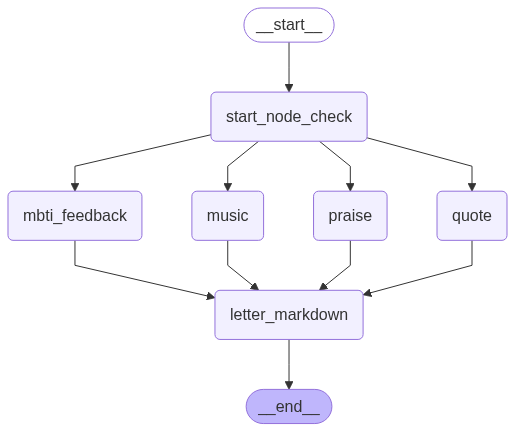

In [7]:
from IPython.display import Image, display

display(Image(letter_graph.get_graph().draw_mermaid_png()))

In [8]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
test_state = {
    'diary_body': """오늘 아침, 나는 오랜만에 조깅을 나갔다. 해가 떠오르기 시작한 시간, 6시. 아침 햇살이 너무 예뻐서 기분이 좋았다. 바람은 선선하고, 몸은 가벼워서 상쾌한 기분이 들었다. 조깅을 하면서 느끼는 그 홀가분한 감정은 언제나 나를 행복하게 만든다. 오늘은 특히나 기분이 좋았다. 아침 시간을 나를 위해 쓴 것 같아 뿌듯함이 느껴졌다. 하지만 운동화를 바꿔야 할 것 같다는 생각이 들었다. 발이 살짝 아팠거든.

오후가 되어 2시 반, 나는 프로젝트 발표를 준비했다. 동료 유재석과 함께한 이 프로젝트는 나에게 많은 의미가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸다. 긴장감이 가득했지만, 막상 말하기 시작하니 점점 긴장이 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 그 순간의 안도감은 이루 말할 수 없었다. 많이 떨렸지만, 결국 잘 해내서 다행이라는 생각이 들었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다.

저녁 8시, 나는 첫눈을 보았다. 언제나처럼 첫눈을 보면 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만, 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 그 순간, 세상의 모든 것이 멈춘 듯한 기분이 들었다. 오늘 하루는 이렇게 기쁨과 두려움, 설렘이 가득한 하루였다. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함이 어우러져 나에게 특별한 하루를 선사해주었다.
    """
}

result = letter_graph.invoke(test_state)



> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...

Invoking: `tavily_search` with `{'query': '성장 명언', 'search_depth': 'basic'}`



Invoking: `spotify_recommender_tool` with `{'diary': '오늘 아침, 나는 오랜만에 조깅을 나갔다. 해가 떠오르기 시작한 시간, 6시. 아침 햇살이 너무 예뻐서 기분이 좋았다. 바람은 선선하고, 몸은 가벼워서 상쾌한 기분이 들었다. 조깅을 하면서 느끼는 그 홀가분한 감정은 언제나 나를 행복하게 만든다. 오늘은 특히나 기분이 좋았다. 아침 시간을 나를 위해 쓴 것 같아 뿌듯함이 느껴졌다. 하지만 운동화를 바꿔야 할 것 같다는 생각이 들었다. 발이 살짝 아팠거든.\n\n오후가 되어 2시 반, 나는 프로젝트 발표를 준비했다. 동료 유재석과 함께한 이 프로젝트는 나에게 많은 의미가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸다. 긴장감이 가득했지만, 막상 말하기 시작하니 점점 긴장이 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 그 순간의 안도감은 이루 말할 수 없었다. 많이 떨렸지만, 결국 잘 해내서 다행이라는 생각이 들었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다.\n\n저녁 8시, 나는 첫눈을 보았다. 언제나처럼 첫눈을 보면 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만, 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 그 순간, 세상의 모든 것이 멈춘 듯한 기분이 들었다. 오늘 하루는 이렇게 기쁨과 두려움, 설렘이 가득한 하루였다. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함이 어우러져 나에게 특별한 하루를 선사해주었다.', 'keyword': '첫눈'}`


제목은 [첫눈처럼 너에게 가겠다], 가수는 [KIM HOJOONG], url은 

In [9]:
from IPython.display import Markdown

display(Markdown(result['letter_markdown']))

# 💌 비밀친구의 편지

너를 위해 작지만 따뜻한 편지를 준비했어.

---

## 🌟 오늘의 칭찬

> 와, 너 오늘 아침에 6시에 일어나서 조깅한 거 진짜 대단한 거 알지? 아침 햇살 받으면서 상쾌하게 뛰었다니, 그거 완전 인생의 승리자야! 진짜 너의 그 부지런함과 자기관리 능력, 나도 좀 나눠줘라! 🌟

---

## 🎵 오늘의 음악 추천

**첫눈처럼 너에게 가겠다** - *KIM HOJOONG*  
🔗 [음악 들으러 가기](https://open.spotify.com/track/3dzJTVPcw9zw1Pmf0z1gIm)  
_👉 첫눈을 보면서 느꼈던 그 포근한 마음을 담아, 이 노래가 너의 특별한 하루를 더 따뜻하게 만들어줄 것 같아. 첫눈처럼 너에게 다가가는 감성을 느껴봐!_

---

## 📝 오늘의 명언

> “성장은 결코 단순한 우연이 아닙니다. 그것은 함께 일하는 힘의 결과입니다.”  
> — *제임스 캐시 페니*  
오늘 하루는 정말 다양한 감정으로 가득했구나. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함까지. 이런 하루를 보내면서 너도 많이 성장했을 거야. 제임스 캐시 페니의 말처럼, 성장은 우연히 이루어지는 게 아니라, 너의 노력과 주변의 힘이 함께 만들어가는 결과야. 오늘의 경험들이 너를 더 단단하게 만들어줄 거야. 앞으로도 계속해서 성장하는 너를 응원할게!

---

## 🌷 F의 위로

오늘 하루 정말 특별했겠다! 아침 조깅하면서 느낀 상쾌함과 뿌듯함, 그리고 프로젝트 발표의 긴장감 속에서도 잘 해낸 너의 모습이 정말 대단해. 준비한 만큼 자연스럽게 전달할 수 있었다니, 그 순간의 안도감이 얼마나 컸을지 상상이 가. 그리고 저녁에 첫눈을 보면서 느낀 포근함까지, 하루를 꽉 채운 다양한 감정들이 너에게 큰 의미로 다가왔을 것 같아. 발이 살짝 아팠던 건 아쉽지만, 그럼에도 불구하고 하루를 잘 견뎌낸 너 자신을 칭찬해주고 싶어. 앞으로도 이런 소중한 순간들이 너에게 많이 찾아오길 바라!

---

## 🧭 T의 조언

조깅하면서 느낀 상쾌함과 발표를 잘 마친 성취감, 그리고 첫눈의 포근함까지, 오늘 하루 정말 알차게 보냈네! 운동화가 발에 불편했다면, 조깅을 꾸준히 하려면 발에 맞는 좋은 운동화를 하나 장만하는 게 좋을 것 같아. 발이 편해야 더 오래, 더 자주 조깅할 수 있으니까. 그리고 발표 준비하면서 긴장했던 부분은, 다음번엔 미리 몇 번 더 연습해보는 것도 좋을 것 같아. 연습이 많을수록 자신감도 더 생기고, 발표할 때 떨림도 줄어들 거야. 오늘 하루 잘 보냈으니, 내일도 힘내자!

---

비밀친구가 여기 있다는 걸 잊지 마.  
내일도 네 편이 되어줄게.

다 잘 될 거야! ☁️
잘 자.

— 너의 비밀친구가 -
